In [36]:
!pip install PROTECA

  Attempting uninstall: PROTECA
    Found existing installation: PROTECA 0.0.1
    Uninstalling PROTECA-0.0.1:
      Successfully uninstalled PROTECA-0.0.1


In [37]:
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip install scipy
!pip install ipywidgets
!pip install scikit-learn==0.23.2
!pip install seaborn 

# Импорт библиотек

In [52]:
from proteca import defences
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import math


In [39]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


# Генерация нормальных данных

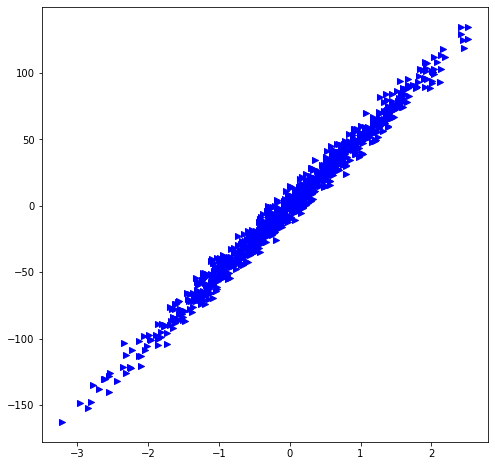

In [40]:
X, Y = make_regression(n_samples = 1000, n_features=1, noise=6)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], Y, color='b', marker='>')
plt.show()

In [41]:
len(Y)

1000

# Обучение модели на нормальных данных и вычисление СКО

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(X, Y)
predict = lin_reg.predict(X)
RMSE_v1 = np.sqrt(mean_squared_error(Y, predict)) #СКО нормальной модели
print(RMSE_v1)



5.975425120967877


# Генерация состязательных данных

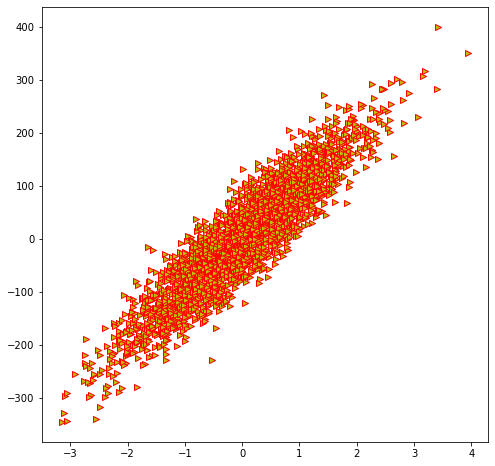

In [43]:
X_, Y_ = make_regression(n_samples = 3000, n_features=1, noise=40)

plt.figure(figsize=(8, 8))
plt.scatter(X_[:, 0], Y_, color='y', edgecolor='r', marker='>')
plt.show()

In [44]:
X_malicious = list()
Y_malicious = list()
lenn = len(X_)
for i in range(lenn):
    if X_[i]<0 and Y_[i]>0:
        X_malicious.append(X_[i])
        Y_malicious.append(Y_[i])


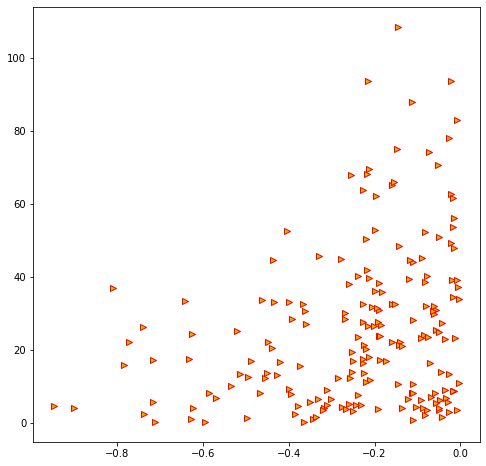

In [45]:
plt.figure(figsize=(8, 8))
plt.scatter(X_malicious, Y_malicious, color='y', edgecolor='r', marker='>')
plt.show()

In [46]:
len(X_malicious)

189

# Смешивание данных

In [47]:
X_ = np.array(X_malicious)
Y_ = np.array(Y_malicious)

In [48]:
data_X = np.concatenate([X, X_])
data_Y = np.concatenate([Y, Y_])
data = np.c_[data_X[:, 0], data_Y]
data

array([[ 1.33505187e+00,  6.55272623e+01],
       [-3.30168063e-01, -1.46007392e+01],
       [ 1.09336904e-01,  7.81914091e+00],
       ...,
       [-6.22368424e-02,  3.19176231e+01],
       [-6.23844682e-01,  3.93092816e+00],
       [-3.77921204e-01,  4.43229350e+00]])

# CКО на смешаных данных

In [49]:
lin_reg_malicious = LinearRegression()
lin_reg_malicious.fit(data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1))
predict_malicious = lin_reg_malicious.predict(X)
RMSE_malicious = np.sqrt(mean_squared_error(Y, predict_malicious)) #СКО модели, обученной на состязательных данных
print(RMSE_malicious)

8.605949067398404


# Нахождение коэффициента степени отравления

In [50]:
k = RMSE_v1/RMSE_malicious
k

0.6943365658070598

# Обеспечение защиты (очистка)

In [66]:
def reg_defense (data, X, X_, Y):
  N = X.shape[0] + X_.shape[0]
  a = X_.shape[0]/ N
  error_list = []
  rmse = list()
  gamma_list = list()
  ind_b_list = list()
  eps_list = list()

  gamma_min = np.arange(0.05, 0.71, 0.01)
  gamma_max = np.arange(0.06, 0.81, 0.01)
  ind_b = np.arange(3, 80, 1)

  lenn_1 = len(gamma_min)
  lenn_2 = len(ind_b)

  count = 0

  for j in range(lenn_1):
      gamma = np.random.randint(data.shape[0]*gamma_min[j], data.shape[0]*gamma_max[j])
      # в ing_gam хранятся рандомные индексы из data 
      ind_gam = np.random.choice(data.shape[0]-1, gamma)
      P_1 = (1 - a)** (gamma/N)
      for super_b in range(lenn_2):
          rmse_ = list()
          b=ind_b[super_b]
          P = (1 - P_1)** b
          eps = P ** b
          for i in range(gamma//b):
              ran_ind = data[ind_gam[b*i:b*(i+1)]]

              lin_reg = LinearRegression()
              lin_reg.fit(ran_ind[:, 0].reshape(-1, 1), ran_ind[:, 1].reshape(-1, 1))
              pred_y = lin_reg.predict(ran_ind[:, 0].reshape(-1, 1))
              pred_norm = lin_reg.predict(X)
              rmse_.append(np.sqrt(mean_squared_error(Y, pred_norm)))

              error_index =  np.abs(ran_ind[:, 1] - pred_y[:, 0]) > eps

              if ran_ind[error_index].shape[0] > 0:
                  error_list += ran_ind[error_index][:, 0].tolist() 
                  
          rmse_.sort()
          rmse.append(rmse_)
          gamma_list.append(gamma)
          ind_b_list.append(b)
          eps_list.append(eps)
      count+=1
      #print(count)
  df = pd.DataFrame()
  df['gamma'] = gamma_list
  df['beta'] = ind_b_list
  df['eps'] = eps_list
  df['rmse'] = rmse

  error_list = np.unique(error_list)
  return df

In [67]:
df = reg_defense(data, X, X_, Y)

In [68]:
df_1 = pd.DataFrame()
df_2 = pd.DataFrame()
df_1['x'] = X.flatten().tolist()
df_1['y'] = Y.tolist()
df_2['x'] = data_X.flatten().tolist()
df_2['y'] = data_Y.tolist()

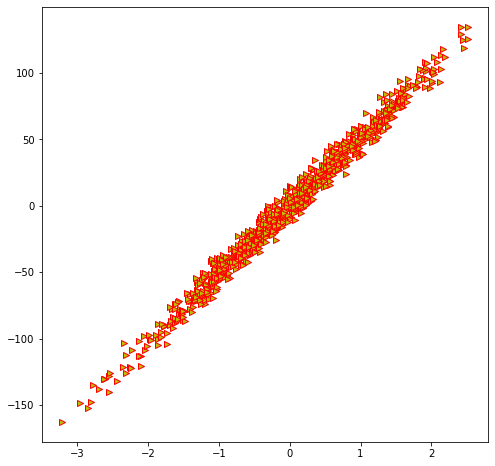

In [69]:
plt.figure(figsize=(8, 8))
plt.scatter(df_1['x'], df_1['y'], color='y', edgecolor='r', marker='>')
plt.show()